In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Veri dönüşümleri (Normalize)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Veri setini yükleme
dataset = datasets.ImageFolder('Data', transform=transform)
class_names = dataset.classes 
print(f"Sınıf isimleri: {class_names}")

# Veri setinin bir alt kümesini seçme (örneğin %10)
subset_indices = np.random.choice(len(dataset), size=int(0.1 * len(dataset)), replace=False)
subset_indices = sorted(subset_indices)  # İndeksleri sıralamak hataları önleyebilir
subset = Subset(dataset, subset_indices)

# Veri setini eğitim ve doğrulama olarak bölme
train_size = int(0.8 * len(subset))
valid_size = len(subset) - train_size
train_subset, valid_subset = torch.utils.data.random_split(subset, [train_size, valid_size])

# Eğitim ve doğrulama veri yükleyicileri
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=32, shuffle=False)

# Sınıf örneklem sayıları
class_counts = [5000, 488, 67222, 13725]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

# Veri yükleyicilere ağırlıklı sampler ekleme
train_sampler_weights = [class_weights[dataset.targets[idx]] for idx in subset_indices[:train_size]]
train_sampler = WeightedRandomSampler(weights=train_sampler_weights, num_samples=len(train_sampler_weights), replacement=True)

train_loader = DataLoader(train_subset, batch_size=32, sampler=train_sampler)
valid_loader = DataLoader(valid_subset, batch_size=32, shuffle=False)


Sınıf isimleri: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [12]:
# Modelin tanımlanması
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Sınıf sayısını belirleme
num_classes = len(class_counts)
model = CNNModel(num_classes)

# Cihaz seçimi (GPU varsa kullan)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)




CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [13]:
# Hiperparametreler
learning_rate = 0.001
epochs = 10

# Kayıp fonksiyonu ve optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)




In [14]:
# Eğitim, doğrulama ve grafik fonksiyonları
train_losses = []
valid_losses = []
valid_accuracies = []

def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epochs} ")
    epoch=0
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(train_loader))
    epoch+=1
    train_losses.append(running_loss/len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

def validate_model(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    valid_losses.append(valid_loss/len(valid_loader))
    valid_accuracies.append(accuracy)
    print(f"Validation Loss: {valid_loss/len(valid_loader)}, Accuracy: {accuracy}%")

def plot_metrics(train_losses, valid_losses, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.show()

def save_model(model, path):
    torch.save(model.state_dict(), path)




Epoch 0 : 100%|██████████| 217/217 [02:15<00:00,  1.61it/s, loss=1.18] 


Epoch 2/0, Loss: 1.184230613200346
Validation Loss: 1.0985536233945326, Accuracy: 70.3875072296125%


Epoch 1 : 100%|██████████| 217/217 [02:18<00:00,  1.56it/s, loss=0.332]


Epoch 2/1, Loss: 0.33156277957771507
Validation Loss: 1.1481094346805052, Accuracy: 83.51648351648352%


Epoch 2 : 100%|██████████| 217/217 [02:18<00:00,  1.56it/s, loss=0.23]  


Epoch 2/2, Loss: 0.22987960151091974
Validation Loss: 0.7792621187188409, Accuracy: 85.07807981492192%


Epoch 3 : 100%|██████████| 217/217 [02:46<00:00,  1.31it/s, loss=0.139] 


Epoch 2/3, Loss: 0.13908037387074962
Validation Loss: 0.8831057724627581, Accuracy: 88.43262001156738%


Epoch 4 : 100%|██████████| 217/217 [02:44<00:00,  1.32it/s, loss=0.125] 


Epoch 2/4, Loss: 0.12528127917487705
Validation Loss: 0.6435198261656544, Accuracy: 87.27588201272413%


Epoch 5 : 100%|██████████| 217/217 [02:43<00:00,  1.33it/s, loss=0.0924]


Epoch 2/5, Loss: 0.09235989367632273
Validation Loss: 0.7290980089794505, Accuracy: 79.2943898207056%


Epoch 6 : 100%|██████████| 217/217 [02:44<00:00,  1.32it/s, loss=0.0974]


Epoch 2/6, Loss: 0.09740423195682088
Validation Loss: 0.6382051780142567, Accuracy: 91.96067090803933%


Epoch 7 : 100%|██████████| 217/217 [02:45<00:00,  1.31it/s, loss=0.0383]


Epoch 2/7, Loss: 0.038251212756482085
Validation Loss: 0.789022379537875, Accuracy: 93.00173510699827%


Epoch 8 : 100%|██████████| 217/217 [02:44<00:00,  1.32it/s, loss=0.088] 


Epoch 2/8, Loss: 0.08798357601007147
Validation Loss: 0.3821315485814756, Accuracy: 91.67148640832852%


Epoch 9 : 100%|██████████| 217/217 [02:44<00:00,  1.32it/s, loss=0.0691]


Epoch 2/9, Loss: 0.06912088958484289
Validation Loss: 0.3947373376312581, Accuracy: 93.4065934065934%


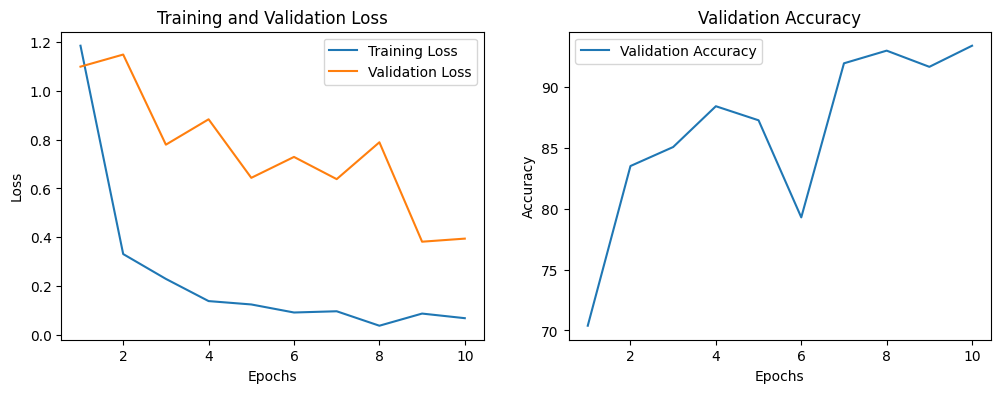

Model 4 sınıf ile başarıyla eğitildi ve kaydedildi.


In [15]:
# Model eğitimi ve doğrulama

for epoch in range(epochs): 
    train_model(model, train_loader, criterion, optimizer, epoch) 
    validate_model(model, valid_loader, criterion)
# Performans grafikleri
plot_metrics(train_losses, valid_losses, valid_accuracies)

# Modeli kaydet
save_model(model, 'demans_model.pth')
print(f"Model {num_classes} sınıf ile başarıyla eğitildi ve kaydedildi.")

